In [20]:
import numpy as np
import glob, os, json
import pickle

import matplotlib.pyplot as plt
import corner
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import multiprocessing as mp

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import time
import scipy
import scipy.integrate as spint

from corner import corner

from astropy.time import Time
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize


from enterprise.pulsar import Pulsar
from enterprise.signals import utils 
from la_forge.core import Core
from la_forge.diagnostics import plot_chains

nano11_pkl = '/home/nima/nanograv/11yr_factlike/NANOGrav_11yr_DE436.pickle'
with open(nano11_pkl, 'rb') as f:
    allpsrs=pickle.load(f)

In [2]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    #golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    golden_mean= 0.3333
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        #'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':False,
        'figure.figsize': figsize(0.98)}

plt.rcParams.update(params)

/home/nima/anaconda3/envs/nano15/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [3]:
import random
def sample_hist(weights, centers, num_points=int(1e5), sample_bounds=None, verbose=False):
    #make sure the weights are properly normalized
    #print(weights)
    #print(centers)
    norm = np.sum(weights)
    normed_weights = weights/norm
    #print(normed_weights)
    
    #go through weights and see if there are lower and upper bounds. This will speed up resampling
    
            
            
    #print("lower, upper bounds are: {} and {}\nthe likelihoods between are {}:".format(lower, upper, normed_weights[lower:upper]))    
    
    
    accepted = 0
    
    resampled_chain = []    
    likelihood_interp = scipy.interpolate.interp1d(centers, normed_weights,kind='cubic')
    interpolate_domain = np.linspace(centers[0], centers[-1], 100*len(centers))
    interpolated_like = np.array([likelihood_interp(el) for el in interpolate_domain])
    
    
    
    
    if sample_bounds is None:
        while accepted < num_points:
            amp = random.uniform(centers[0], centers[-1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)
    else:
        while accepted < num_points:
            amp = random.uniform(sample_bounds[0], sample_bounds[1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)
    
    #fig, ax1 = plt.subplots()            
    #ax1.scatter(interpolate_domain, interpolated_like, label='Distribution Interpolator', marker='*', s=2)
    #ax1.set_ylim(0, max(interpolated_like) * 1.1)
    #ax2 = ax1.twinx()
    #ax2.hist(resampled_chain, density=True, histtype='step', label='Resampled Histogram', bins=30)
    #plt.show()
    #print(sorted(resampled_chain))
    return sorted(resampled_chain)

# Bootstrap from lookup tables

In [ ]:
def lookup_resampler(psr):
    if os.path.exists('/home/nima/nanograv/11yr_factlike/lookup_tables_highres/{}/'.format(psr.name)):
        print('found high-res lookup table')
        lookupdir = '/home/nima/nanograv/11yr_factlike/lookup_tables_highres/{}/'.format(psr.name)
    else:
        print("did not find high-res lookup table")
        lookupdir = '/home/nima/nanograv/11yr_factlike/lookup_tables_final/{}/'.format(psr.name)
    looktable_path = lookupdir + '{}_lookup.txt'.format(psr.name)
    looktable = np.loadtxt(looktable_path)

    parfile = lookupdir + 'pars.txt'
    with open(parfile, 'r') as f:
        parlines=f.readlines()

    pardict = {}
    for parline in parlines:
        key, np_pars = parline.split(';')

        start,stop,num = np_pars.split(',')
        pardict[key] = np.linspace(float(start), float(stop), int(num), endpoint=True)
        #print(pardict)
    lookup_shape = (len(pardict['ramp_log10_A']), len(pardict['ramp_t0']), len(pardict['sign'])) #let's do this intelligently

    reshaped_looktable = np.reshape(looktable, lookup_shape, order='F')



    amps = pardict['ramp_log10_A']
    t0s = pardict['ramp_t0']
    signs = pardict['sign']

    pos_chaindir = '/home/nima/nanograv/11yr_factlike/bayesian_verification/individual_pulsars_fixed_sign/{}_1/'.format(psr.name)
    neg_chaindir = '/home/nima/nanograv/11yr_factlike/bayesian_verification/individual_pulsars_fixed_sign/{}_-1/'.format(psr.name)

    pos_core = Core(label='', chaindir=pos_chaindir)
    neg_core = Core(label='', chaindir=neg_chaindir)

    pos_amps = sorted(pos_core.get_param('{}_ramp_log10_A'.format(psr.name)))
    neg_amps = sorted(neg_core.get_param('{}_ramp_log10_A'.format(psr.name)))

    ####################################
    ##  MAKE l10A POSTS FOR EACH SIGN ##
    ####################################

    log10_A_post = np.zeros(len(amps)) 

    print("First and last epochs: {}, {}".format(min(t0s), max(t0s)))

    #Do once for each sign
    for sign_idx, sign in enumerate(signs):
        if sign < 0:
            masked_bayes_amps = neg_amps
        else:
            masked_bayes_amps = pos_amps

        for log10A_idx in range(len(log10_A_post)):
            submtx_max = np.amax(reshaped_looktable[log10A_idx, :, sign_idx])
            #print(submtx_max)
            #print(np.amin(reshaped_looktable[log10A_idx, :, :]))
            this_l10A_likes = np.zeros(len(t0s)) # populate a grid to integrate over to find the
                                                 # epoch-averaged likelihood for this amplitude
                
            

            for t0_idx, t0 in enumerate(t0s):
                # need to add them all into this_l10A_like
                #if reshaped_looktable[log10A_idx, t0_idx, sign_idx]-submtx_max > 10:
                #    print("Large likelihood diff")
                like = np.exp(reshaped_looktable[log10A_idx, t0_idx, sign_idx]-submtx_max)
                corrected_like = like
                #corrected_like = like
                #hardcoded B1855 reweight
                this_l10A_likes[t0_idx] = corrected_like
            
            this_l10A_like = spint.simpson(y=this_l10A_likes, x=t0s)

            log10_A_post[log10A_idx] = np.log(this_l10A_like) + submtx_max


        #post-process the log10_amps
        reduced_post=log10_A_post - np.amax(log10_A_post)
        post = np.exp(reduced_post)    
        for amp_idx, amp in enumerate(amps):
            post[amp_idx] = 10**amp * post[amp_idx]
        resampled_amp_posterior = sample_hist(post, amps, verbose=False, sample_bounds=[-17, -10],num_points=int(1e5))


        a95_resampled_amps = int(0.95*len(resampled_amp_posterior))
        a95_masked_bayes_amps = int(0.95*len(masked_bayes_amps))

        mcmc_ul95 = masked_bayes_amps[a95_masked_bayes_amps]
        lookup_ul95 = resampled_amp_posterior[a95_resampled_amps]
        
        pctdiff = 100*(10**(lookup_ul95) - 10**(mcmc_ul95))/10**(mcmc_ul95)
        
        np.savetxt(lookupdir + '/resampled_{}.txt'.format(sign), resampled_amp_posterior)

        plt.hist(resampled_amp_posterior, histtype='step', density=True, bins=40, color='tab:red')
        plt.hist(masked_bayes_amps, histtype='step', density=True, bins=40, color='tab:blue')
        plt.title('{} Amp Posterior (sign = {}, diff = {:.03f})'.format(psr.name, sign, pctdiff))
        plt.axvline(resampled_amp_posterior[a95_resampled_amps], linestyle='--', color='red', label='Lookup UL95')
        plt.axvline(masked_bayes_amps[a95_masked_bayes_amps], linestyle='--', color='tab:blue', label='MCMC UL95')
        plt.legend()
        plt.show()
    

[0]


# What the heck is going on with J1918 and J1455?

In [66]:
def compute_ul95(distribution, domain):
    
    hires_domain = np.linspace(domain[0], domain[-1], int(len(domain)*100))
    interpolator = scipy.interpolate.interp1d(domain, distribution, kind='cubic')
    hires_integrand = interpolator(hires_domain)
    full_integral = spint.simpson(hires_integrand,x=hires_domain)
    
    domain_idx = 0
    running_integrand = spint.simpson(hires_integrand[domain_idx:domain_idx+2], x=hires_domain[domain_idx:domain_idx+2])
    while running_integrand/full_integral < 0.95:
        domain_idx += 1
        running_integrand += spint.simpson(hires_integrand[domain_idx:domain_idx+2], x=hires_domain[domain_idx:domain_idx+2])
    
    return hires_domain[domain_idx]

def lookup_resampler_choose(psr, highres = False, trim_epoch = True):
    
    if highres == True and os.path.exists('/home/nima/nanograv/11yr_factlike/lookup_tables_highres/{}/'.format(psr.name)):
        #print('found high-res lookup table')
        lookupdir = '/home/nima/nanograv/11yr_factlike/lookup_tables_highres/{}/'.format(psr.name)
    else:
        #print("did not find high-res lookup table")
        lookupdir = '/home/nima/nanograv/11yr_factlike/lookup_tables_final/{}/'.format(psr.name)
    
    looktable_path = lookupdir + '{}_lookup.txt'.format(psr.name)
    looktable = np.loadtxt(looktable_path)

    parfile = lookupdir + 'pars.txt'
    with open(parfile, 'r') as f:
        parlines=f.readlines()

    pardict = {}
    for parline in parlines:
        key, np_pars = parline.split(';')

        start,stop,num = np_pars.split(',')
        pardict[key] = np.linspace(float(start), float(stop), int(num), endpoint=True)
        #print(pardict)
    lookup_shape = (len(pardict['ramp_log10_A']), len(pardict['ramp_t0']), len(pardict['sign'])) #let's do this intelligently

    reshaped_looktable = np.reshape(looktable, lookup_shape, order='F')



    amps = pardict['ramp_log10_A']
    t0s = pardict['ramp_t0']
    signs = pardict['sign']

    if trim_epoch:
        eps=9
        U,_ = utils.create_quantization_matrix(psr.toas)
        tmin_mjd = np.floor(max(U[:,eps] * psr.toas/24/3600))
        tmax_mjd = np.ceil(max(U[:,-eps] * psr.toas/24/3600))
        
        tmin_idx = np.argmin(np.abs(t0s - tmin_mjd))
        tmax_idx = np.argmin(np.abs(t0s - tmax_mjd))
        
        print("not looking for bursts between MJD {} and MJD {}".format(t0s[0], tmin_mjd))
        cols = np.arange(tmin_idx, tmax_idx)
        
    else:
        cols=np.arange(len(t0s))
    
    pos_chaindir = '/home/nima/nanograv/11yr_factlike/bayesian_verification/individual_pulsars_fixed_sign/{}_1/'.format(psr.name)
    neg_chaindir = '/home/nima/nanograv/11yr_factlike/bayesian_verification/individual_pulsars_fixed_sign/{}_-1/'.format(psr.name)

    pos_core = Core(label='', chaindir=pos_chaindir)
    neg_core = Core(label='', chaindir=neg_chaindir)

    pos_amps = sorted(pos_core.get_param('{}_ramp_log10_A'.format(psr.name)))
    neg_amps = sorted(neg_core.get_param('{}_ramp_log10_A'.format(psr.name)))

    ####################################
    ##  MAKE l10A POSTS FOR EACH SIGN ##
    ####################################

    log10_A_post = np.zeros(len(amps)) 

    #print("First and last epochs: {}, {}".format(t0s[cols[0]], t0s[cols[-1]]))

    #Do once for each sign
    for sign_idx, sign in enumerate(signs):
        if sign < 0:
            masked_bayes_amps = neg_amps
            core=neg_core
        else:
            masked_bayes_amps = pos_amps
            core=pos_core
        for log10A_idx in range(len(log10_A_post)):
            submtx_max = np.amax(reshaped_looktable[log10A_idx, :, sign_idx])
            #print(submtx_max)
            #print(np.amin(reshaped_looktable[log10A_idx, :, :]))
            this_l10A_likes = np.zeros(len(cols)) # populate a grid to integrate over to find the
                                                 # epoch-averaged likelihood for this amplitude
                

            for ii, t0_idx in enumerate(cols):
                # need to add them all into this_l10A_like
                #if reshaped_looktable[log10A_idx, t0_idx, sign_idx]-submtx_max > 10:
                #    print("Large likelihood diff")
                like = np.exp(reshaped_looktable[log10A_idx, t0_idx, sign_idx]-submtx_max)
                corrected_like = like
                #corrected_like = like
                #hardcoded B1855 reweight
                this_l10A_likes[ii] = corrected_like

            # only need to integrate over the bounds of my custom columns  
            this_l10A_like = spint.simpson(y=this_l10A_likes, x=t0s[cols[0]:cols[-1]+1])
            log10_A_post[log10A_idx] = np.log(this_l10A_like) + submtx_max


        #post-process the log10_amps
        reduced_post=log10_A_post - np.amax(log10_A_post)
        post = np.exp(reduced_post)    
        for amp_idx, amp in enumerate(amps):
            post[amp_idx] = 10**amp * post[amp_idx]
                
        resampled_ul95 = compute_ul95(post, amps)
        if trim_epoch:
            resampled_outdir = '/home/nima/nanograv/11yr_factlike/lookup_tables_final/{}/{}/'.format(psr.name,'resampled_trimmed')
        else:
            resampled_outdir = '/home/nima/nanograv/11yr_factlike/lookup_tables_final/{}/{}/'.format(psr.name,'resampled')
        os.makedirs(resampled_outdir, exist_ok=True)
        
        #np.savetxt(resampled_outdir + 'resampled_{}.txt'.format(int(sign)),resampled_amp_posterior)
        
        
        #==========================================
        # MAKE PLOTS
        #==========================================
        mcmc_t0s = core.get_param('ramp_t0')
        t0mask = np.zeros(len(mcmc_t0s), dtype=bool)
        for ii, val in enumerate(mcmc_t0s):
            if val > t0s[cols[0]] and val < t0s[cols[-1]]:
                t0mask[ii] = True

        mcmc_samples = sorted(core.get_param('{}_ramp_log10_A'.format(psr.name))[t0mask])
        mcmc_ul95 = mcmc_samples[int(0.95 * len(mcmc_samples))]


        #n, bins, patches = plt.hist(resampled_highres, histtype='step',label='Lookup High Res', density=True, bins=30)\
        if trim_epoch:
            trim_label=' (Trimmed)'
        else:
            trim_label=''
        plt.scatter(amps,post/spint.simpson(post,amps),label="Lookup{}".format(trim_label))
        plt.hist(mcmc_samples, histtype='step', label='MCMC samples', density=True, bins=40)

        resampled_pctdiff = 100*(10**resampled_ul95 - 10**mcmc_ul95)/(10**mcmc_ul95)
        plt.axvline(x=resampled_ul95, ls='--', color = 'tab:blue')
        plt.axvline(x=mcmc_ul95, ls='--', color = 'tab:orange')

        plt.legend()
        plt.title("PSR {} (sign={}){}\nLow-res %-diff: {:.03f}".format(psr.name, sign, trim_label,resampled_pctdiff))
        plt.show()

        #highres_pctdiff = 100*(10**highres_ul95 - 10**mcmc_ul95)/(10**mcmc_ul95) 
        


In [67]:
def resample_worker(psr):
    #high_res_lookupdir = '/home/nima/nanograv/11yr_factlike/lookup_tables_highres/{}/'.format(psr.name)
    low_res_lookupdir = '/home/nima/nanograv/11yr_factlike/lookup_tables_final/{}/'.format(psr.name)
    bayesian_chaindir = '/home/nima/nanograv/11yr_factlike/bayesian_verification//'
    
    looktable_path = low_res_lookupdir + '{}_lookup.txt'.format(psr.name)
    parfile = low_res_lookupdir + 'pars.txt'
    with open(parfile, 'r') as f:
        parlines=f.readlines()

    pardict = {}
    for parline in parlines:
        key, np_pars = parline.split(';')

        start,stop,num = np_pars.split(',')
        pardict[key] = np.linspace(float(start), float(stop), int(num), endpoint=True)
        #print(pardict)
    lookup_shape = (len(pardict['ramp_log10_A']), len(pardict['ramp_t0']), len(pardict['sign'])) #let's do this intelligently
    t0s = pardict['ramp_t0']
    
    
    
    # need to do 3 things:
    # -resample high res lookup
    # -resample low res lookup
    # -plot bayesian 
    #resampled_highres = lookup_resampler_choose(psr, highres=True)

    lookup_resampler_choose(psr, highres=False, trim_epoch=True)
    lookup_resampler_choose(psr, highres=False, trim_epoch=False)
    #highres_ul95 = resampled_highres[int(0.95 * len(resampled_highres))]


In [68]:
test_psrs = []
for psr in allpsrs:
    if psr.name == 'J1455-3330' or psr.name == 'J1918-0642':
        test_psrs.append(psr)

not looking for bursts between MJD 53397.01097847137 and MJD 53766.0


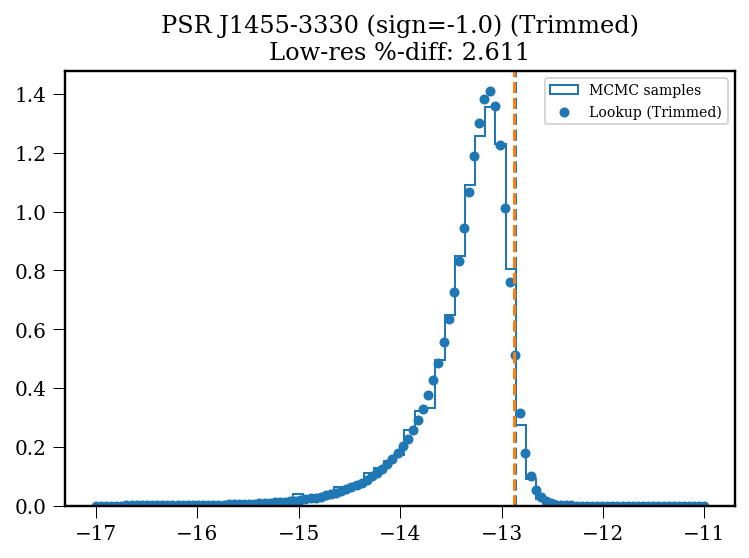

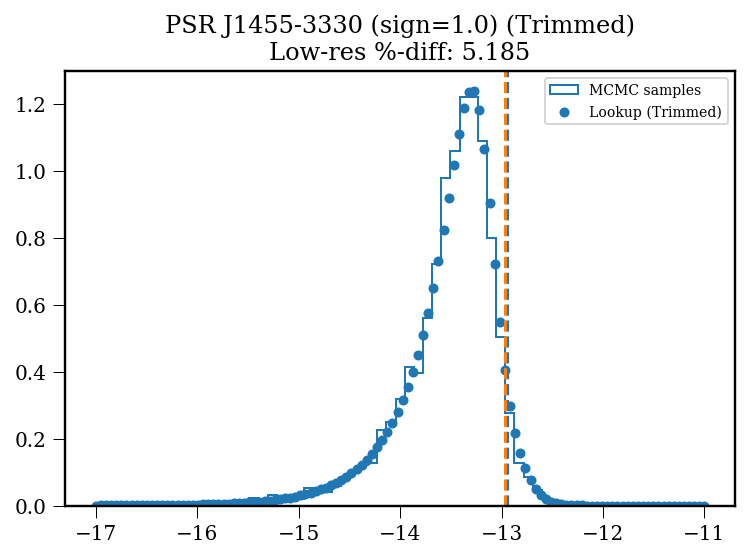

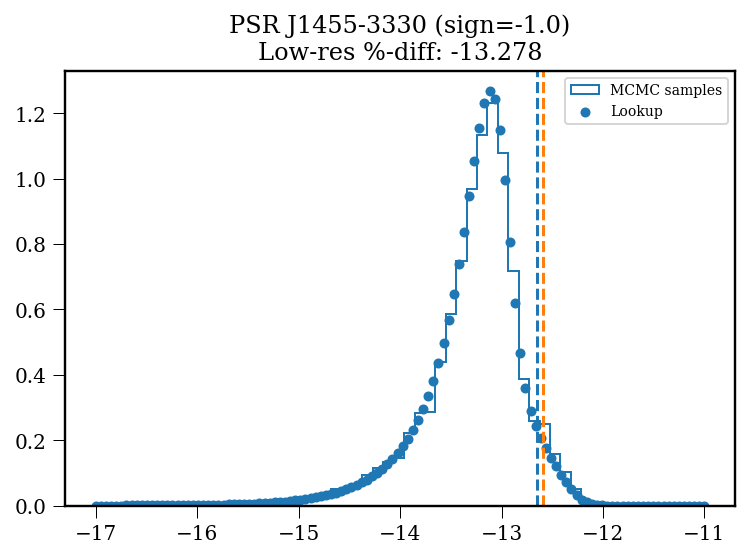

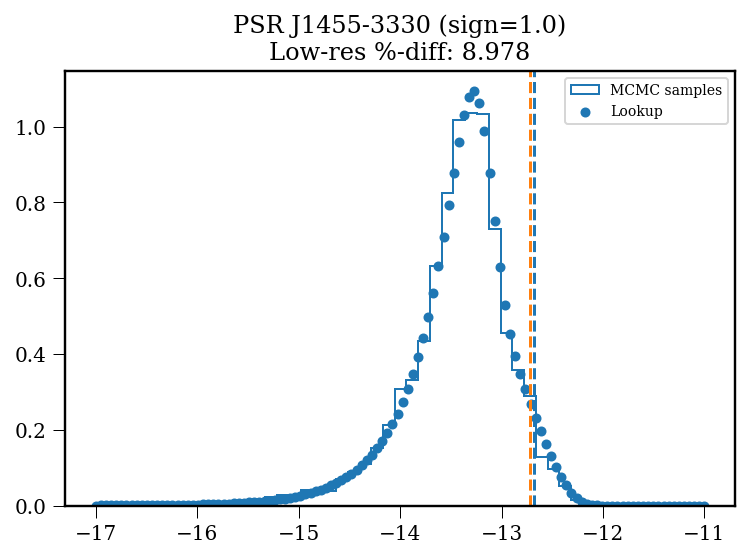

not looking for bursts between MJD 53472.06272390708 and MJD 53839.0


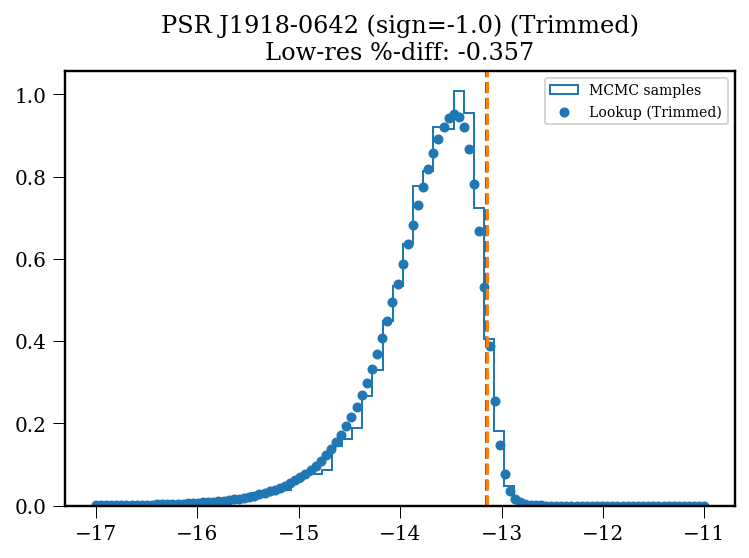

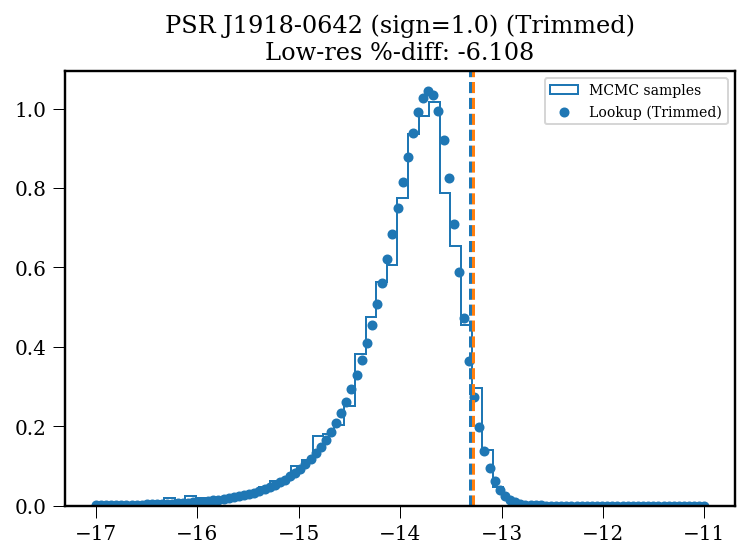

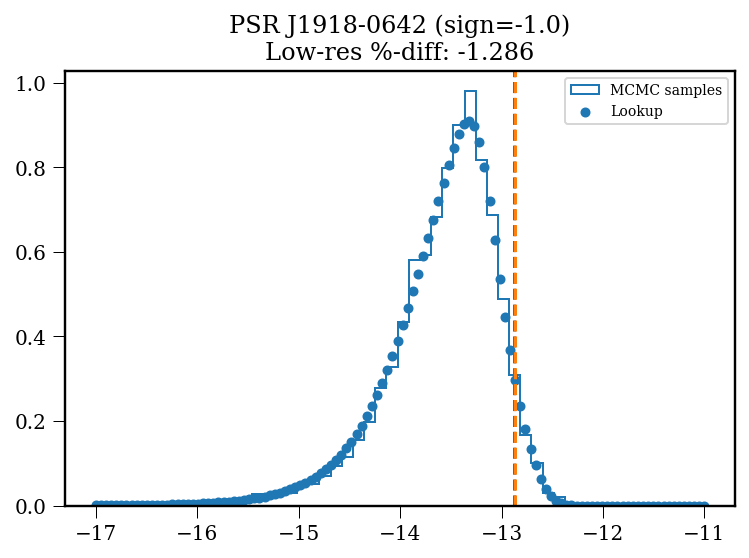

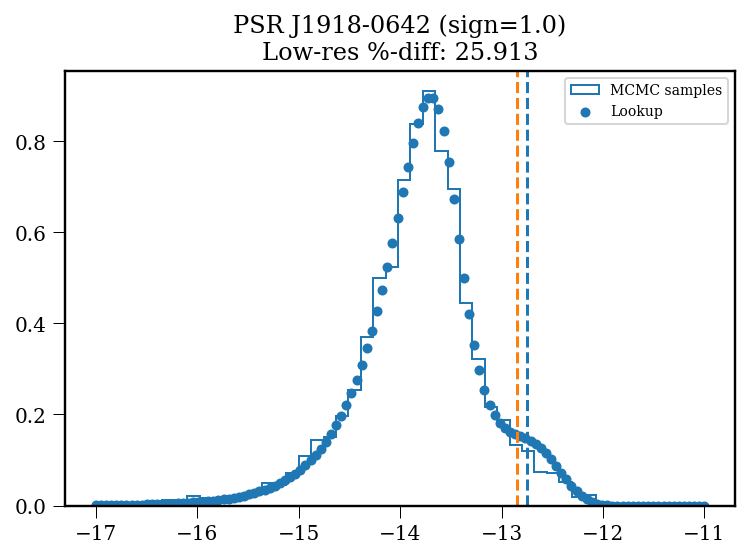

In [70]:
for psr in test_psrs:
    resample_worker(psr)

In [ ]:
pool = mp.Pool(processes=10)
pool.map(resample_worker, allpsrs)

In [ ]:
# let's just compare the resulting samples
for psr in allpsrs:
    high_res_lookupdir = '/home/nima/nanograv/11yr_factlike/lookup_tables_highres/{}/'.format(psr.name)
    low_res_lookupdir = '/home/nima/nanograv/11yr_factlike/lookup_tables_final/{}/'.format(psr.name)
    bayesian_chaindir = '/home/nima/nanograv/11yr_factlike/bayesian_verification/individual_pulsars_fixed_sign/'
    
    for sign in [-1, 1]:
        # need to do 3 things:
        # -resample high res lookup
        # -resample low res lookup
        # -plot bayesian 
        #resampled_highres = lookup_resampler_choose(psr, highres=True)
        
        resampled_lowres = lookup_resampler_choose(psr, highres=False)
        
        highres_ul95 = resampled_highres[int(0.95 * len(resampled_highres))]
        lowres_ul95 = resampled_highres[int(0.95 * len(resampled_lowres))]
        
        
        chaindir = '/home/nima/nanograv/11yr_factlike/bayesian_verification/individual_pulsars_fixed_sign/{}_{}/'.format(psr.name, sign)
        core = Core(label='', chaindir = chaindir)
        mcmc_samples = sorted(core.get_param('{}_ramp_log10_A'.format(psr.name)))
        mcmc_ul95 = mcmc_samples[int(0.95 * len(mcmc_samples))]
        
        
        n, bins, patches = plt.hist(resampled_highres, histtype='step',label='Lookup High Res', density=True, bins=30)
        plt.hist(resampled_lowres, histtype='step',label='Lookup Low Res', density=True, bins=bins)
        plt.hist(mcmc_samples, histtype='step', label='MCMC samples', density=True, bins=bins)
        
        plt.axvline(x=highres_ul95, ls='--', color = 'tab:blue')
        plt.axvline(x=lowres_ul95, ls='--', color = 'tab:orange')
        plt.axvline(x=mcmc_ul95, ls='--', color = 'tab:green')
        
        plt.legend()
        plt.title("PSR {} (sign={})".format(psr.name, sign))
        plt.show()
        
        highres_pctdiff = 100*(10**highres_ul95 - 10**mcmc_ul95)/(10**mcmc_ul95) 
        lowres_pctdiff = 100*(10**lowres_ul95 - 10**mcmc_ul95)/(10**mcmc_ul95) 
        print('PSR {}, sign {} ======================================================='.format(psr.name, sign))
        print('High-res %-diff: {:.03f}\nLow-res %-diff: {:.03f}'.format(highres_pctdiff, lowres_pctdiff))

In [ ]:
import corner

for psr in test_psrs:
    for sign in [-1,1]:
        mcmc_chaindir = '/home/nima/nanograv/11yr_factlike/bayesian_verification/individual_pulsars_fixed_sign/{}_{}/'.format(psr.name, sign)
        core = Core(label='', chaindir = mcmc_chaindir, )
        plot_chains(core,hist=True,linestyle='--', 
                    pars=['{}_ramp_log10_A'.format(psr.name), 'ramp_t0'.format(psr.name), '{}_red_noise_gamma'.format(psr.name), '{}_red_noise_log10_A'.format(psr.name)], 
                    suptitle='PSR {}, sign={}'.format(psr.name, sign), ncols=2, title_y=1.03)
        
        # Let's also make corner plots
        epochs = core.get_param('ramp_t0')
        amps = core.get_param('{}_ramp_log10_A'.format(psr.name))
        
        samples = []
        for el in epochs:
            samples.append(el)
        for el in amps:
            samples.append(el)
        samples = np.array(samples)
        samples = samples.reshape((len(amps),2), order='F')
        
        corner.corner(samples, labels=['ramp_t0','{}_ramp_log10_A'.format(psr.name)],plot_contours=True, levels=[0.25, 0.5, 0.75, 0.9])